In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import stats, interpolate, spatial
from IPython.display import HTML
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import seaborn as sn
from mpl_toolkits import mplot3d
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
import random
import multiprocessing
from joblib import Parallel, delayed
import os
from pathlib import Path
NumThread = (multiprocessing.cpu_count() - 1) * 2
import pickle
from multiprocessing import cpu_count, Pool
import glob
from scipy.spatial.distance import cdist


In [2]:
T = 4
scale = 0.008

In [3]:
res = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/results.npy', allow_pickle=True).item()

all_ftles = {(T, scale): res}
vc = all_ftles[(T, scale)]['vc']
ly_ids = all_ftles[(T, scale)]['ly_ids']

#Austin's function :
def unpackvcs(vcs, ids):
    unpacked = []
    trial = []
    for i in range(len(ids)):
        if i == 0:
            trial.append(vcs[:, i])
        elif ids[i] == ids[i - 1]:
            trial.append(vcs[:, i])
        else:
            unpacked.append(np.array(trial))
            trial = []
            trial.append(vcs[:, i])
        if i == len(ids) - 1:
            unpacked.append(np.array(trial))
    return unpacked

embedded_traj = unpackvcs(vc, ly_ids)

1. Mean Peak Velocity Calculation: The overall mean peak velocity is calculated by taking the mean of the peak velocities from all the given trajectories.
2. A function get_timepoints_before_mean_peak is defined to extract the 5 points for each trajectory before the overall mean peak velocity.
3. Collecting Timepoints: The 5 timepoints before the overall mean peak velocity for all the trajectories are collected.
4. Computing Pairwise Distances: The pairwise distances between the sets of 5 timepoints for all trajectories are computed using Euclidean distance.
5. Summing Distances: The distances are summed for each trajectory.
6. Identifying Closest and Furthest Trajectories: The 10 closest and 10 furthest trajectories are identified by sorting the summed distances.

In [4]:
# Function to get the 5 timepoints before the overall mean peak velocity for each trajectory
def get_timepoints_before_mean_peak(traj, mean_peak):
    closest_index_to_peak = np.argmin(np.abs(traj[:, 1] + mean_peak))
    return traj[closest_index_to_peak-5:closest_index_to_peak, 1:3] if closest_index_to_peak >= 5 else None

timepoints_before_peak = [get_timepoints_before_mean_peak(traj, mean_peak_velocity_all) for traj in embedded_traj]
timepoints_before_peak = np.array([item for item in timepoints_before_peak if item is not None])

# Compute pairwise distances for the selected timepoints
distance_matrix = cdist(timepoints_before_peak.reshape(-1, 10), timepoints_before_peak.reshape(-1, 10), metric='euclidean')

# Sum distances for each trajectory
distances = np.sum(distance_matrix, axis=1)
closest_trajectories = np.argsort(distances)[:10]
furthest_trajectories = np.argsort(distances)[-10:]

plt.figure(figsize=(12, 6))
plt.suptitle('Closest and Furthest Trajectories Based on 5 Points Before Overall Mean Peak Velocity')

# closest trajectories
plt.subplot(1, 2, 1)
for i in closest_trajectories:
    plt.plot(-embedded_traj[i][:, 1], embedded_traj[i][:, 2])  # Flip the velocity here
plt.axvline(x=mean_peak_velocity_all, color='gray', linestyle='--')
plt.xlabel('Velocity')
plt.ylabel('Acceleration')
plt.title('10 Closest Trajectories')

# furthest 
plt.subplot(1, 2, 2)
for i in furthest_trajectories:
    plt.plot(-embedded_traj[i][:, 1], embedded_traj[i][:, 2])  # Flip the velocity here
plt.axvline(x=mean_peak_velocity_all, color='gray', linestyle='--')
plt.xlabel('Velocity')
plt.ylabel('Acceleration')
plt.title('10 Furthest Trajectories')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

NameError: name 'mean_peak_velocity_all' is not defined

### Function Modification for 3D: The get_timepoints_before_mean_peak function now returns the entire timepoints of interest, including the position (3D).

1. Collecting Timepoints for 3D: The 5 timepoints before the overall mean peak velocity for all trajectories are collected in 3D.
2. 3D Pairwise Distances: Pairwise distances are computed using all three dimensions (position, velocity, acceleration).
3. Closest and Furthest Trajectories: Identifying the 10 closest and 10 furthest trajectories as before.

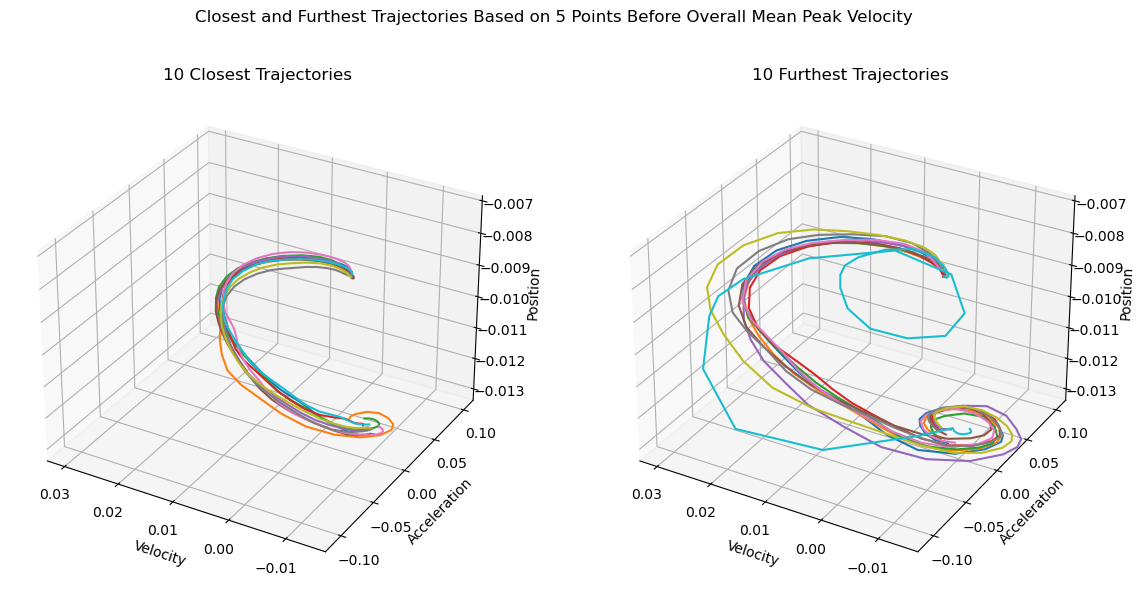

In [ ]:
# Function to get the 5 timepoints before the overall mean peak velocity for each trajectory
def get_timepoints_before_mean_peak(traj, mean_peak):
    closest_index_to_peak = np.argmin(np.abs(traj[:, 1] + mean_peak))
    return traj[closest_index_to_peak-5:closest_index_to_peak, :] if closest_index_to_peak >= 5 else None

timepoints_before_peak = [get_timepoints_before_mean_peak(traj, mean_peak_velocity_all) for traj in embedded_traj]
timepoints_before_peak = np.array([item for item in timepoints_before_peak if item is not None])

# pairwise distances for the selected timepoints
distance_matrix = cdist(timepoints_before_peak.reshape(-1, 15), timepoints_before_peak.reshape(-1, 15), metric='euclidean')

#Sum of distances for each trajectory
distances = np.sum(distance_matrix, axis=1)

closest_trajectories = np.argsort(distances)[:10]
furthest_trajectories = np.argsort(distances)[-10:]

# limits for each axis 
padding = 0.1  
x_range = [min(-embedded_traj[i][:, 1].min() for i in furthest_trajectories),
           max(-embedded_traj[i][:, 1].max() for i in furthest_trajectories)]
y_range = [min(embedded_traj[i][:, 2].min() for i in furthest_trajectories),
           max(embedded_traj[i][:, 2].max() for i in furthest_trajectories)]
z_range = [min(embedded_traj[i][:, 0].min() for i in furthest_trajectories),
           max(embedded_traj[i][:, 0].max() for i in furthest_trajectories)]

x_limits = [x_range[0] - padding * (x_range[1] - x_range[0]),
            x_range[1] + padding * (x_range[1] - x_range[0])]
y_limits = [y_range[0] - padding * (y_range[1] - y_range[0]),
            y_range[1] + padding * (y_range[1] - y_range[0])]
z_limits = [z_range[0] - padding * (z_range[1] - z_range[0]),
            z_range[1] + padding * (z_range[1] - z_range[0])]

fig = plt.figure(figsize=(12, 6))
plt.suptitle('Closest and Furthest Trajectories Based on 5 Points Before Overall Mean Peak Velocity')

#10 closest trajectories
ax1 = fig.add_subplot(121, projection='3d')
for i in closest_trajectories:
    ax1.plot(-embedded_traj[i][:, 1], embedded_traj[i][:, 2], embedded_traj[i][:, 0])  
ax1.set_xlabel('Velocity')
ax1.set_ylabel('Acceleration')
ax1.set_zlabel('Position')
ax1.set_title('10 Closest Trajectories')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax1.set_zlim(z_limits)
#furthest
ax2 = fig.add_subplot(122, projection='3d')
for i in furthest_trajectories:
    ax2.plot(-embedded_traj[i][:, 1], embedded_traj[i][:, 2], embedded_traj[i][:, 0])  # Flip 
ax2.set_xlabel('Velocity')
ax2.set_ylabel('Acceleration')
ax2.set_zlabel('Position')
ax2.set_title('10 Furthest Trajectories')
ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
ax2.set_zlim(z_limits)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
